# Applied Question

In [1]:
## Common Packages
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
import random
import matplotlib.pyplot as plt
import seaborn as sns


## Packages for this assignment
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures


In [2]:
Weekly = load_data('Weekly')
Weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [3]:
Index = list(Weekly.columns)

Index.remove('Direction')
Index.remove('Year')


## a. Descriptive & Visual Exploration

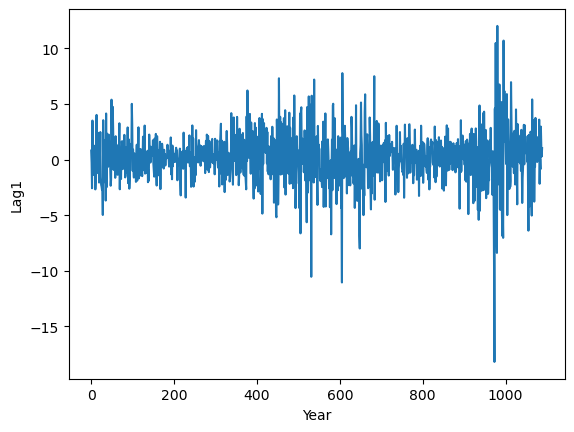

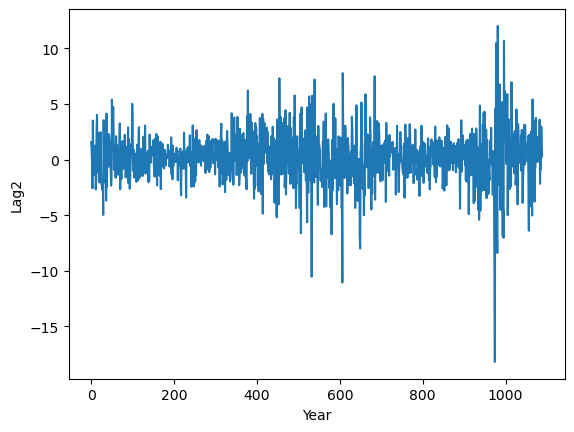

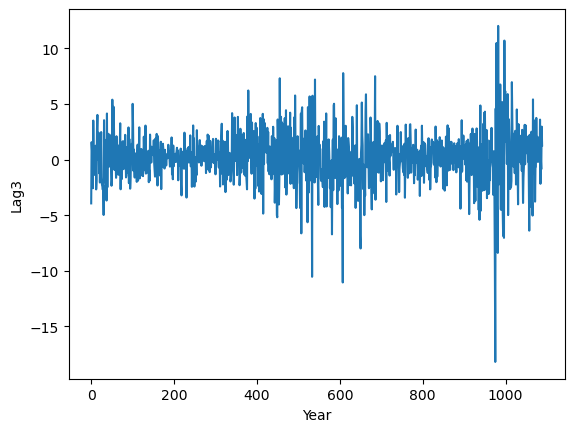

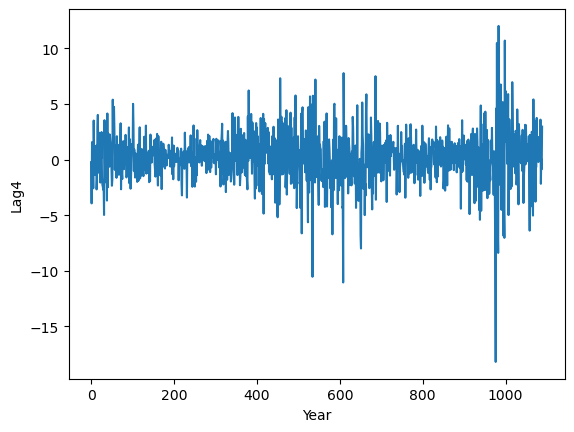

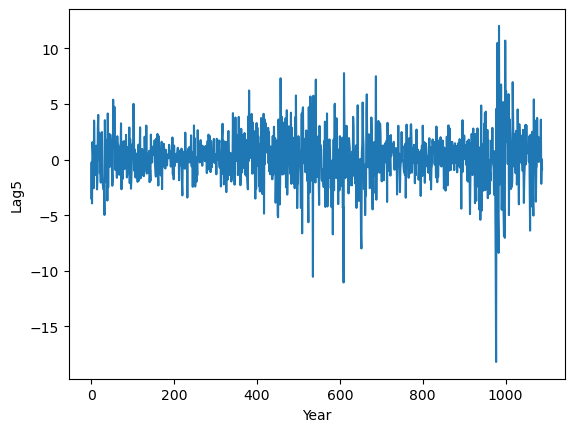

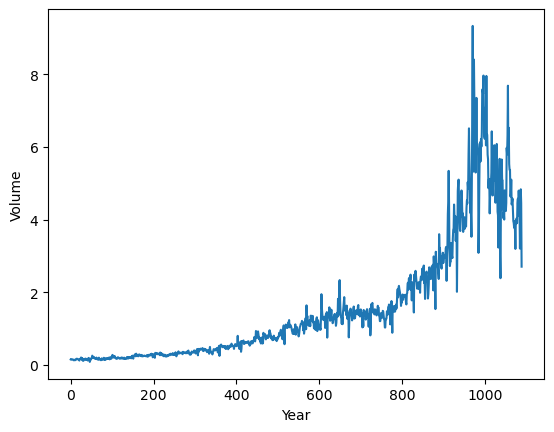

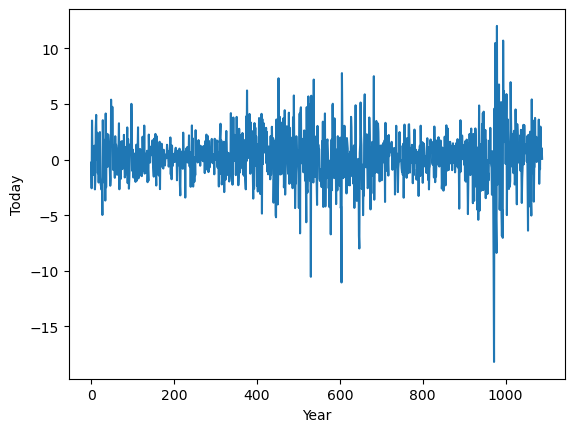

In [4]:

for X in Index:
        #plt.scatter(Weekly['Year'], Weekly[X])
        plt.plot(Weekly[X])
        plt.ylabel(X)
        plt.xlabel("Year")
        plt.show()

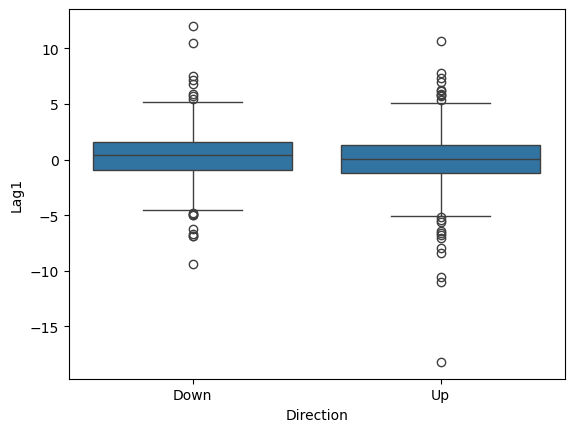

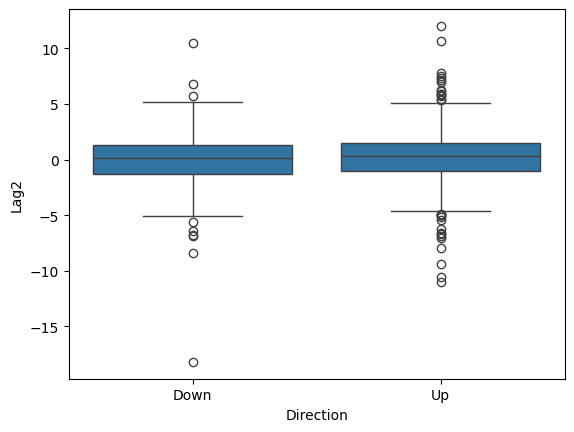

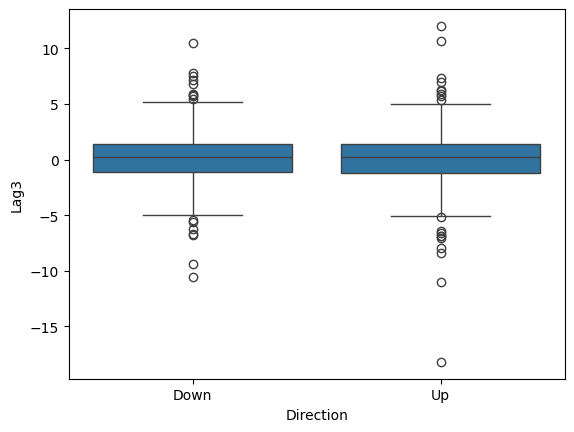

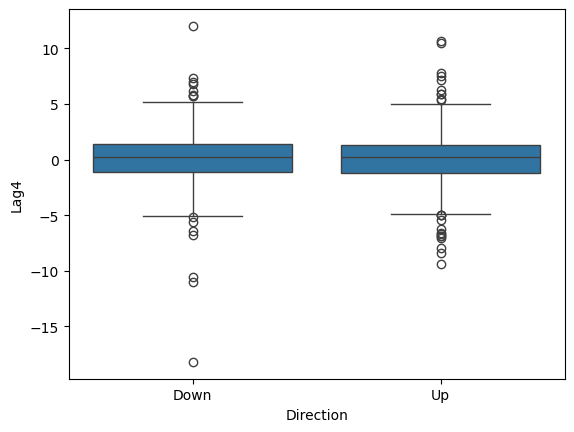

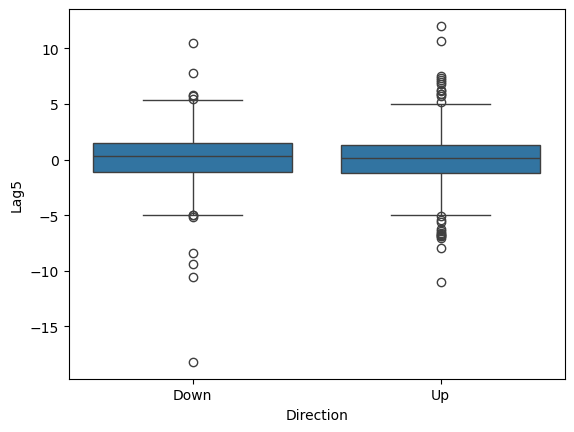

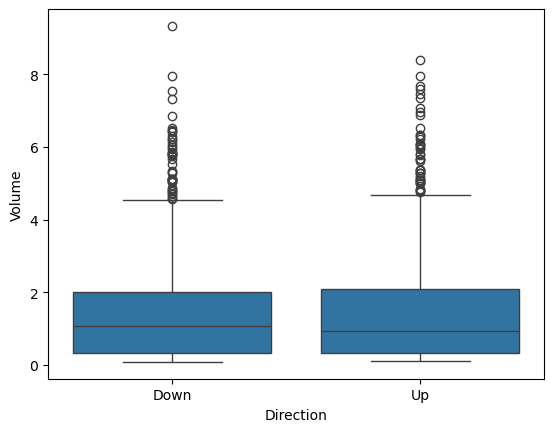

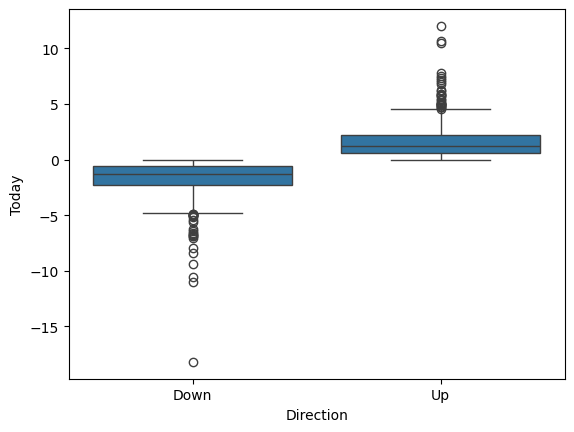

In [5]:
for X in Index:
        sns.boxplot(y = Weekly[X], x = Weekly['Direction'])
        plt.ylabel(X)
        plt.show()

https://www.geeksforgeeks.org/create-a-correlation-matrix-using-python/#

In [6]:
matrix = np.corrcoef(Weekly[Index])
print(matrix)

[[ 1.         -0.24995329  0.19329753 ...  0.74140128 -0.08254982
   0.26645333]
 [-0.24995329  1.         -0.4467835  ...  0.1859839   0.6058956
  -0.27824217]
 [ 0.19329753 -0.4467835   1.         ...  0.17554553  0.18610948
   0.37228607]
 ...
 [ 0.74140128  0.1859839   0.17554553 ...  1.          0.57468355
   0.4722855 ]
 [-0.08254982  0.6058956   0.18610948 ...  0.57468355  1.
   0.27137439]
 [ 0.26645333 -0.27824217  0.37228607 ...  0.4722855   0.27137439
   1.        ]]


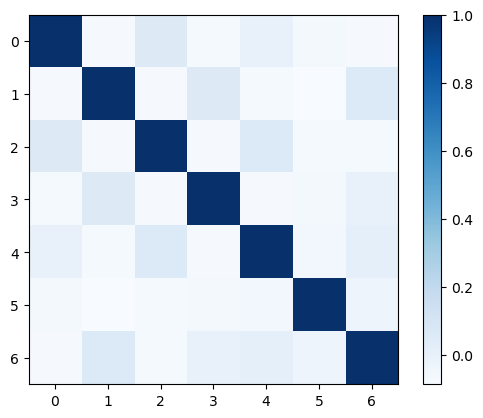

In [7]:
matrix = Weekly[Index].corr()

# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

## b. Logistic Regression

In [8]:
allvars = Weekly.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Weekly)
y = Weekly.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


Lag2 is the only significant predictor. 

## c. Confusion Matrix

In [9]:
# Make Predictions
probs = results.predict()

# Label prediction over .5 as 'Up'
labels = np.array(['Down']*1089)
labels[probs>0.5] = "Up"

# Create Table
confusion_table(labels, Weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [10]:
np.mean(labels == Weekly.Direction)

0.5610651974288338

In [11]:
(54+557)/1089

0.5610651974288338

## d. Test/Train Simple Logistic Model

In [12]:
train = (Weekly.Year < 2009)
Weekly_train = Weekly.loc[train]
Weekly_test = Weekly.loc[~train]
Weekly_test.shape

D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

### Logistic Regression

In [13]:
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Confusion Table
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [14]:
(9+56)/104

0.625

## e. LDA Model

In [15]:
lda = LDA(store_covariance=True)

X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [16]:
lda.means_


array([[-0.03568254],
       [ 0.26036581]])

In [17]:
lda.classes_


array(['Down', 'Up'], dtype='<U4')

In [18]:
lda.priors_

array([0.44771574, 0.55228426])

In [19]:
lda_pred = lda.predict(X_test)
# Print Confusion Table
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [20]:
(9+56)/104

0.625

## f. QDA Model

In [21]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [22]:
qda.means_, qda.priors_


(array([[-0.03568254],
        [ 0.26036581]]),
 array([0.44771574, 0.55228426]))

In [23]:
qda_pred = qda.predict(X_test)
# Print Confusion Table
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [24]:
(0+61)/104

0.5865384615384616

## g. KNN with k=1

In [25]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,22,31
Up,21,30


In [26]:
(22+30)/104

0.5

## i. Best Model

Logistic Regression and LDA preformed equally the best based on the fraction of correctness. 

## j. Model Improvement

### Adding Other Predictors

In [27]:
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2033    0.064  3.162  0.002
Lag2       0.0581    0.029  2.024  0.043
0.625


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [28]:
model = MS(['Lag2', 'Lag1']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2111    0.065  3.269  0.001
Lag2       0.0538    0.029  1.854  0.064
Lag1      -0.0542    0.029 -1.878  0.060
0.5769230769230769


Truth,Down,Up
Predicted,,
Down,7,8
Up,36,53


In [29]:
model = MS(['Lag2', 'Lag3']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2050    0.064  3.182  0.001
Lag2       0.0571    0.029  1.983  0.047
Lag3      -0.0122    0.029 -0.425  0.671
0.625


Truth,Down,Up
Predicted,,
Down,8,4
Up,35,57


In [30]:
model = MS(['Lag2', 'Lag4']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2054    0.064  3.189  0.001
Lag2       0.0594    0.029  2.062  0.039
Lag4      -0.0174    0.028 -0.611  0.541
0.625


Truth,Down,Up
Predicted,,
Down,8,4
Up,35,57


In [31]:
model = MS(['Lag2', 'Lag5']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2074    0.064  3.218  0.001
Lag2       0.0565    0.029  1.959  0.050
Lag5      -0.0297    0.029 -1.035  0.301
0.6057692307692307


Truth,Down,Up
Predicted,,
Down,7,5
Up,36,56


In [32]:
model = MS(['Lag2', 'Volume']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2707    0.090  3.006  0.003
Lag2       0.0535    0.029  1.842  0.066
Volume    -0.0555    0.052 -1.071  0.284
0.5384615384615384


Truth,Down,Up
Predicted,,
Down,20,25
Up,23,36


In [33]:
model = MS(['Lag2', 'Lag3', 'Lag4']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2075    0.065  3.215  0.001
Lag2       0.0584    0.029  2.022  0.043
Lag3      -0.0139    0.029 -0.482  0.630
Lag4      -0.0187    0.029 -0.652  0.514
0.6153846153846154


Truth,Down,Up
Predicted,,
Down,8,5
Up,35,56


### Adding Polynomials and Interactions Logistic Regression

#### Square Term

In [34]:
Weekly['Lag2_2'] = Weekly['Lag2']**2

In [35]:
model = MS(['Lag2_2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.1958    0.068  2.878  0.004
Lag2_2     0.0028    0.005  0.609  0.543
0.5865384615384616


Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


Squaring Lags removes directional signs biasing the model. 

#### Cube Terms

In [36]:
Weekly['Lag1_3'] = Weekly['Lag1']**3
Weekly['Lag2_3'] = Weekly['Lag2']**3
Weekly['Lag3_3'] = Weekly['Lag3']**3
Weekly['Lag4_3'] = Weekly['Lag4']**3
Weekly['Lag5_3'] = Weekly['Lag5']**3

In [37]:
model = MS(['Lag2','Lag1_3']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2011    0.064  3.121  0.002
Lag2       0.0593    0.029  2.021  0.043
Lag1_3    -0.0009    0.001 -1.322  0.186
0.625


Truth,Down,Up
Predicted,,
Down,8,4
Up,35,57


In [38]:
model = MS(['Lag2','Lag2_3']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


               coef  std err      z  P>|z|
intercept  0.203300    0.064  3.158  0.002
Lag2       0.057700    0.033  1.727  0.084
Lag2_3     0.000008    0.000  0.021  0.983
0.625


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [39]:
model = MS(['Lag2','Lag3_3']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2026    0.064  3.152  0.002
Lag2       0.0563    0.029  1.955  0.051
Lag3_3    -0.0003    0.000 -0.649  0.516
0.625


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [40]:
model = MS(['Lag2','Lag4_3']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2044    0.064  3.179  0.001
Lag2       0.0569    0.029  1.978  0.048
Lag4_3     0.0002    0.000  0.646  0.518
0.625


Truth,Down,Up
Predicted,,
Down,8,4
Up,35,57


In [41]:
model = MS(['Lag2','Lag5_3']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2048    0.064  3.183  0.001
Lag2       0.0630    0.029  2.170  0.030
Lag5_3     0.0004    0.000  1.101  0.271
0.625


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [42]:
model = MS(['Lag2','Lag2_3']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
confusion_table(labels, L_test)


               coef  std err      z  P>|z|
intercept  0.203300    0.064  3.158  0.002
Lag2       0.057700    0.033  1.727  0.084
Lag2_3     0.000008    0.000  0.021  0.983
0.625


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


#### Interactions

In [43]:
Weekly['Lag2_Lag1'] = Weekly['Lag2']*Weekly['Lag1']
Weekly['Lag2_Lag3'] = Weekly['Lag2']*Weekly['Lag3']
Weekly['Lag2_Lag4'] = Weekly['Lag2']*Weekly['Lag4']
Weekly['Lag2_Lag5'] = Weekly['Lag2']*Weekly['Lag5']

In [44]:
model = MS(['Lag2','Lag2_Lag1']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
# Print Confusion Table
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2058    0.064  3.197  0.001
Lag2       0.0566    0.029  1.949  0.051
Lag2_Lag1  0.0061    0.007  0.886  0.376
0.5865384615384616


Truth,Down,Up
Predicted,,
Down,3,3
Up,40,58


In [45]:
model = MS(['Lag2','Lag2_Lag3']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
# Print Confusion Table
confusion_table(labels, L_test)


               coef  std err      z  P>|z|
intercept  0.203200    0.064  3.160  0.002
Lag2       0.058000    0.030  1.907  0.056
Lag2_Lag3 -0.000033    0.007 -0.005  0.996
0.625


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [46]:
model = MS(['Lag2','Lag2_Lag4']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
# Print Confusion Table
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2078    0.064  3.223  0.001
Lag2       0.0516    0.030  1.748  0.080
Lag2_Lag4 -0.0098    0.009 -1.066  0.286
0.5769230769230769


Truth,Down,Up
Predicted,,
Down,3,4
Up,40,57


In [47]:
model = MS(['Lag2','Lag2_Lag5']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
print(summarize(results))
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
# Print Accuracy
print(np.mean(labels == L_test))
# Print Confusion Table
confusion_table(labels, L_test)


             coef  std err      z  P>|z|
intercept  0.2037    0.064  3.167  0.002
Lag2       0.0591    0.029  2.037  0.042
Lag2_Lag5  0.0018    0.007  0.246  0.806
0.6346153846153846


Truth,Down,Up
Predicted,,
Down,9,4
Up,34,57


### LDA, QDA, and KNN Improvements

#### LDA

In [48]:
lda = LDA(store_covariance=True)

X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

lda_pred = lda.predict(X_test)
# Print Accuracy
print(np.mean(lda_pred == L_test))
# Print Confusion Table
confusion_table(lda_pred, L_test)

0.6346153846153846


Truth,Down,Up
Predicted,,
Down,9,4
Up,34,57


#### QDA

In [49]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_pred = qda.predict(X_test)
# Print Accuracy
print(np.mean(qda_pred == L_test))

# Print Confusion Table
confusion_table(qda_pred, L_test)

0.5096153846153846


Truth,Down,Up
Predicted,,
Down,5,13
Up,38,48


#### KNN

##### KNN: Adjust n with only Lag2

In [50]:
knn1 = KNeighborsClassifier(n_neighbors=1)
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5


Truth,Down,Up
Predicted,,
Down,22,31
Up,21,30


In [51]:
knn1 = KNeighborsClassifier(n_neighbors=2)
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.47115384615384615


Truth,Down,Up
Predicted,,
Down,31,43
Up,12,18


In [52]:
knn1 = KNeighborsClassifier(n_neighbors=3)
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5480769230769231


Truth,Down,Up
Predicted,,
Down,16,20
Up,27,41


In [53]:
knn1 = KNeighborsClassifier(n_neighbors=4)
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5769230769230769


Truth,Down,Up
Predicted,,
Down,26,27
Up,17,34


In [54]:
knn1 = KNeighborsClassifier(n_neighbors=5)
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5384615384615384


Truth,Down,Up
Predicted,,
Down,16,21
Up,27,40


In [55]:
knn1 = KNeighborsClassifier(n_neighbors=6)
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5096153846153846


Truth,Down,Up
Predicted,,
Down,20,28
Up,23,33


In [56]:
knn1 = KNeighborsClassifier(n_neighbors=7)
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5480769230769231


Truth,Down,Up
Predicted,,
Down,16,20
Up,27,41


##### KNN: Adjust n with Lag2 and Lag2*Lag5

In [57]:
knn1 = KNeighborsClassifier(n_neighbors=1)
model = MS(['Lag2','Lag2_Lag5']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5096153846153846


Truth,Down,Up
Predicted,,
Down,16,24
Up,27,37


In [58]:
knn1 = KNeighborsClassifier(n_neighbors=2)
model = MS(['Lag2','Lag2_Lag5']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5096153846153846


Truth,Down,Up
Predicted,,
Down,31,39
Up,12,22


In [59]:
knn1 = KNeighborsClassifier(n_neighbors=3)
model = MS(['Lag2','Lag2_Lag5']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5192307692307693


Truth,Down,Up
Predicted,,
Down,16,23
Up,27,38


In [60]:
knn1 = KNeighborsClassifier(n_neighbors=4)
model = MS(['Lag2','Lag2_Lag5']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.47115384615384615


Truth,Down,Up
Predicted,,
Down,24,36
Up,19,25


In [61]:
knn1 = KNeighborsClassifier(n_neighbors=5)
model = MS(['Lag2','Lag2_Lag5']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5192307692307693


Truth,Down,Up
Predicted,,
Down,17,24
Up,26,37


In [62]:
knn1 = KNeighborsClassifier(n_neighbors=6)
model = MS(['Lag2','Lag2_Lag5']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5


Truth,Down,Up
Predicted,,
Down,25,34
Up,18,27


In [63]:
knn1 = KNeighborsClassifier(n_neighbors=7)
model = MS(['Lag2','Lag2_Lag5']).fit(Weekly)
X = model.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
# Print Accuracy
print(np.mean(knn1_pred == L_test))
# Print Confusion Table
confusion_table(knn1_pred, L_test)

0.5576923076923077


Truth,Down,Up
Predicted,,
Down,19,22
Up,24,39


# Multi-Class Prediction of Obesity Risk

## Import Data

In [64]:
obese = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Predictors = list(obese.columns)
Predictors.remove('NObeyesdad')
Predictors

['id',
 'Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS']

In [65]:
obese


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II


In [66]:
obese = pd.get_dummies(obese, columns=['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'], drop_first = False)
test = pd.get_dummies(test, columns=['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'], drop_first = False)


In [67]:
obese


,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,...,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,...,True,False,False,True,False,False,False,False,True,False
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,...,True,False,False,False,True,True,False,False,False,False
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,...,True,False,False,False,True,False,False,False,True,False
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,...,True,False,False,True,False,False,False,False,True,False
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,Obesity_Type_II,...,True,False,False,True,False,False,False,False,True,False
20754,20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,Insufficient_Weight,...,True,False,False,True,False,False,False,False,True,False
20755,20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,Obesity_Type_II,...,True,False,False,False,True,False,False,False,True,False
20756,20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,Overweight_Level_II,...,True,False,False,False,True,True,False,False,False,False


In [153]:
Predictors = list(obese.columns)
Predictors
Quants = list(['Age',  'Height',  'Weight',  'FCVC',  'NCP',  'CH2O',  'FAF',  'TUE',])

In [69]:
Predictors.remove('NObeyesdad')
Predictors

['id',
 'Age',
 'Height',
 'Weight',
 'FCVC',
 'NCP',
 'CH2O',
 'FAF',
 'TUE',
 'Gender_Female',
 'Gender_Male',
 'family_history_with_overweight_no',
 'family_history_with_overweight_yes',
 'FAVC_no',
 'FAVC_yes',
 'CAEC_Always',
 'CAEC_Frequently',
 'CAEC_Sometimes',
 'CAEC_no',
 'SMOKE_no',
 'SMOKE_yes',
 'SCC_no',
 'SCC_yes',
 'CALC_Frequently',
 'CALC_Sometimes',
 'CALC_no',
 'MTRANS_Automobile',
 'MTRANS_Bike',
 'MTRANS_Motorbike',
 'MTRANS_Public_Transportation',
 'MTRANS_Walking']

## Correlation Matrix

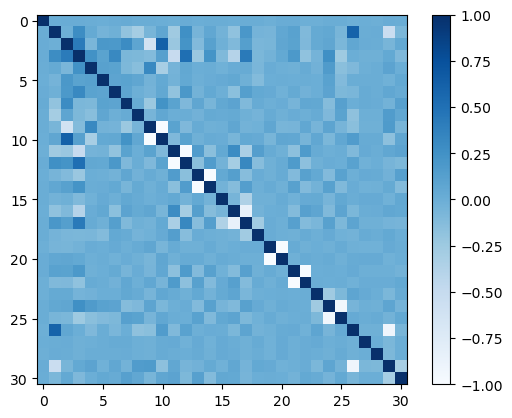

In [151]:
matrix = obese[Predictors].corr()

# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

## Normality

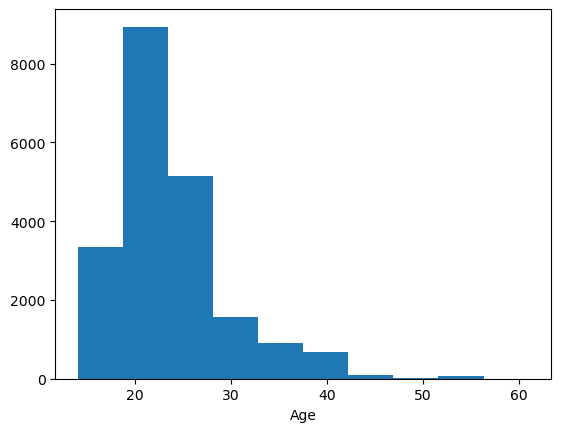

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=14.0, statistic_sign=-1)


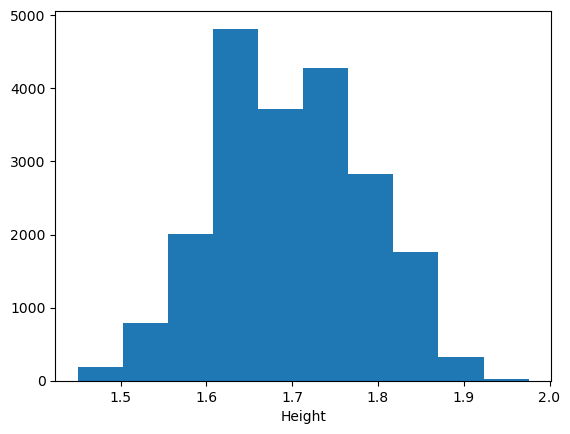

KstestResult(statistic=0.9319884437836518, pvalue=0.0, statistic_location=1.5, statistic_sign=-1)


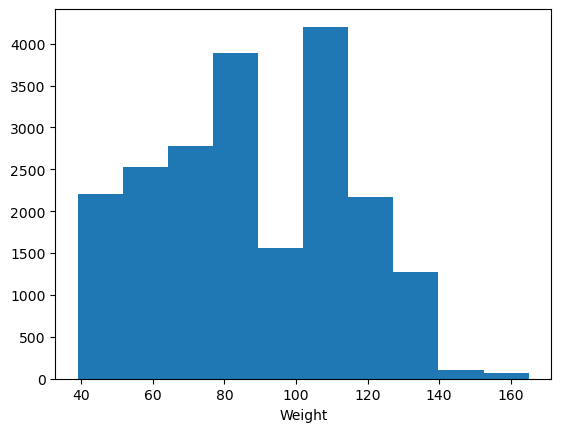

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=39.0, statistic_sign=-1)


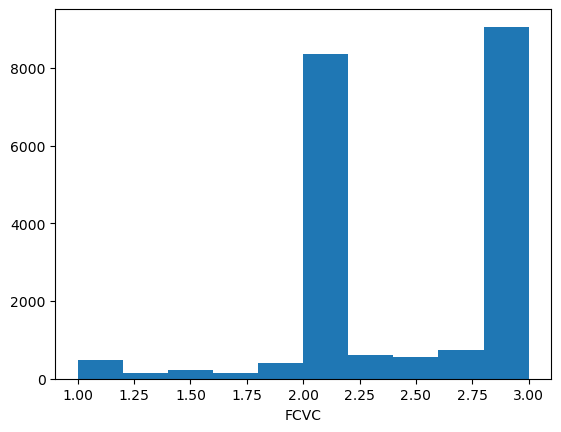

KstestResult(statistic=0.9169079127459642, pvalue=0.0, statistic_location=1.826251, statistic_sign=-1)


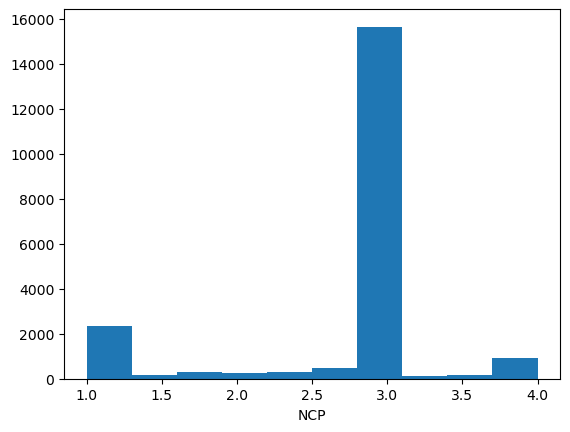

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1.0, statistic_sign=-1)


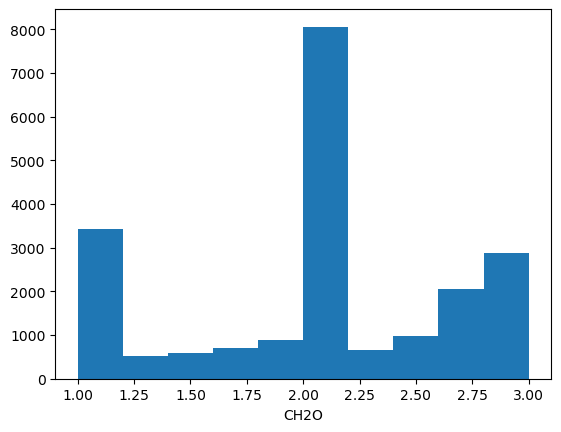

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1.0, statistic_sign=-1)


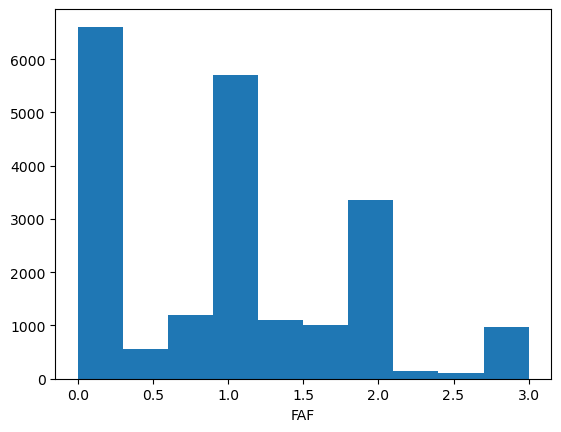

KstestResult(statistic=0.5, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)


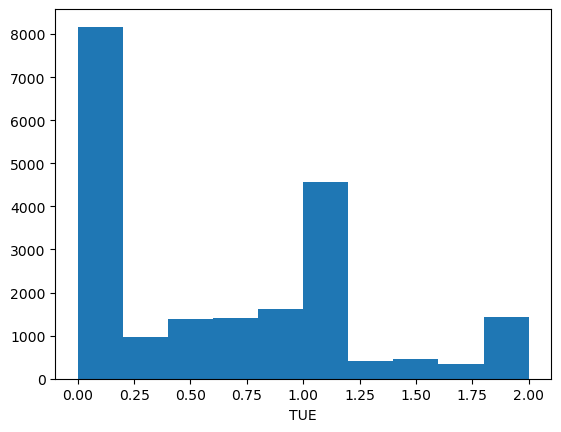

KstestResult(statistic=0.5, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)


In [155]:
from scipy.stats import kstest

for X in Quants:
        plt.hist(obese[X])
        plt.xlabel(X)
        plt.show()
        print(kstest(obese[X], 'norm'))

# Models w/ Age & Weight

## Multinomail Logistic Regression (Age & Weight)

In [125]:
X_train, X_test, Y_train, Y_test = train_test_split(obese[['Weight', 'Age']], obese['NObeyesdad'], random_state=0, test_size=0.2)
X_train.shape

(16606, 2)

https://machinelearningmastery.com/multinomial-logistic-regression-with-python/

In [71]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(multi_class='multinomial', max_iter = 100000)

model.fit(X_train, Y_train)

C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=100000, multi_class='multinomial')

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [72]:
model.classes_

array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II'], dtype=object)

In [73]:
model.coef_

array([[-0.52481607, -0.30523893],
       [-0.29818499, -0.11512473],
       [ 0.12166735,  0.03413721],
       [ 0.42534214,  0.32146471],
       [ 0.39765057,  0.07196443],
       [-0.1254534 , -0.03734461],
       [ 0.0037944 ,  0.03014193]])

In [74]:
model.feature_names_in_

array(['Weight', 'Age'], dtype=object)

In [75]:
labels = model.predict(X_train)
# Print Confusion Table
confusion_table(labels, Y_train)

Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1627,531,2,0,1,22,0
Normal_Weight,414,1463,7,0,2,496,125
Obesity_Type_I,0,5,810,187,134,186,419
Obesity_Type_II,1,0,124,1293,4,11,62
Obesity_Type_III,0,0,517,1084,3096,0,0
Overweight_Level_I,1,421,55,0,1,874,312
Overweight_Level_II,2,32,813,11,1,366,1094


In [118]:
(1627+1463+810+1293+3096+874+1094)/X_train.shape[0]

0.6176683126580754

In [77]:
labels = model.predict(X_test)
# Print Accuracy
print(np.mean(labels == Y_test))
# Print Confusion Table
confusion_table(labels, Y_test)

0.6168111753371869


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,387,125,1,0,0,4,2
Normal_Weight,88,381,1,0,0,134,31
Obesity_Type_I,1,7,205,54,23,44,104
Obesity_Type_II,0,0,22,317,4,2,9
Obesity_Type_III,0,0,107,299,779,0,0
Overweight_Level_I,2,104,14,0,0,207,79
Overweight_Level_II,0,13,232,3,1,81,285


## LDA Model (Age & Weight)

In [78]:
lda = LDA(store_covariance=True)
lda.fit(X_train, Y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [79]:
lda_pred = lda.predict(X_train)
# Print Confusion Table
confusion_table(lda_pred, Y_train)

Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1669,549,2,0,1,29,0
Normal_Weight,370,1512,11,0,2,593,126
Obesity_Type_I,0,4,804,182,133,146,383
Obesity_Type_II,1,0,122,1062,1,0,22
Obesity_Type_III,0,0,510,1320,3100,0,1
Overweight_Level_I,0,335,222,2,2,839,691
Overweight_Level_II,5,52,657,9,0,348,789


In [80]:
(1669+1512+804+1062+3100+839+789)/X_train.shape[0]

0.5886426592797784

In [81]:
lda_pred = lda.predict(X_test)
# Print Accuracy
print(np.mean(lda_pred == Y_test))
# Print Confusion Table
confusion_table(lda_pred, Y_test)

0.588150289017341


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,392,128,1,0,0,4,2
Normal_Weight,83,396,1,0,0,160,30
Obesity_Type_I,0,5,205,53,24,37,91
Obesity_Type_II,0,0,19,273,0,1,4
Obesity_Type_III,0,0,108,344,782,0,0
Overweight_Level_I,2,87,61,0,0,190,179
Overweight_Level_II,1,14,187,3,1,80,204


## QDA Model (Age & Weight)

In [126]:
qda = QDA(store_covariance=True)
qda.fit(X_train, Y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [127]:
qda_pred = qda.predict(X_train)
# Print Confusion Table
confusion_table(qda_pred, Y_train)

Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1736,644,2,0,1,31,0
Normal_Weight,302,1459,14,0,2,622,123
Obesity_Type_I,2,14,1180,159,24,104,327
Obesity_Type_II,1,0,113,1341,30,0,4
Obesity_Type_III,0,0,105,1063,3180,0,25
Overweight_Level_I,2,303,91,1,1,750,560
Overweight_Level_II,2,32,823,11,1,448,973


In [128]:
(1736+1459+1180+1341+3180+750+973)/X_train.shape[0]

0.6394676622907383

In [129]:
qda_pred = qda.predict(X_test)
# Print Accuracy
print(np.mean(qda_pred == Y_test))
# Print Confusion Table
confusion_table(qda_pred, Y_test)

0.6302986512524085


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,404,145,1,0,0,5,2
Normal_Weight,67,388,1,0,0,167,29
Obesity_Type_I,3,6,284,53,3,26,85
Obesity_Type_II,0,0,17,330,8,0,1
Obesity_Type_III,0,0,19,287,795,0,4
Overweight_Level_I,3,75,26,0,0,174,147
Overweight_Level_II,1,16,234,3,1,100,242


### Export Predictions for Kaggle

In [133]:

obese_level = qda.predict(test[['Weight', 'Age']])
print(obese_level)

output = pd.DataFrame(test[['id']])
output['NObeyesdad'] = obese_level
print(output)
output.to_csv('model_QDA_AgeWeight.csv', index = False)

['Obesity_Type_II' 'Normal_Weight' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Insufficient_Weight' 'Obesity_Type_II']
          id           NObeyesdad
0      20758      Obesity_Type_II
1      20759        Normal_Weight
2      20760     Obesity_Type_III
3      20761       Obesity_Type_I
4      20762     Obesity_Type_III
...      ...                  ...
13835  34593   Overweight_Level_I
13836  34594   Overweight_Level_I
13837  34595  Insufficient_Weight
13838  34596  Insufficient_Weight
13839  34597      Obesity_Type_II

[13840 rows x 2 columns]


## Naive Bayes Model (Age & Weight)

In [86]:
NB = GaussianNB()
NB.fit(X_train, Y_train)

GaussianNB()

In [87]:
NB.classes_


array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II'], dtype='<U19')

In [88]:
NB.class_prior_


array([0.12314826, 0.14765747, 0.14019029, 0.15506443, 0.19504998,
       0.11772853, 0.12116103])

In [89]:
nb_labels = NB.predict(X_train)
# Print Confusion Table
confusion_table(nb_labels, Y_train)

Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1735,637,2,0,1,31,0
Normal_Weight,303,1481,14,0,2,625,131
Obesity_Type_I,0,2,854,211,6,76,342
Obesity_Type_II,1,0,61,1160,1,0,3
Obesity_Type_III,0,0,486,1192,3227,0,9
Overweight_Level_I,3,298,92,1,1,782,570
Overweight_Level_II,3,34,819,11,1,441,957


In [90]:
(1735+1481+854+1160+3227+782+957)/X_train.shape[0]

0.6139949415873781

In [91]:
nb_labels = NB.predict(X_test)
# Print Accuracy
print(np.mean(nb_labels == Y_test))
# Print Confusion Table
confusion_table(nb_labels, Y_test)

0.6074181117533719


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,404,144,1,0,0,5,2
Normal_Weight,69,394,1,0,0,166,31
Obesity_Type_I,0,2,213,54,0,20,87
Obesity_Type_II,0,0,13,285,0,0,0
Obesity_Type_III,0,0,95,331,806,0,1
Overweight_Level_I,4,74,26,0,0,181,150
Overweight_Level_II,1,16,233,3,1,100,239


## SVM (Age & Weight)

In [139]:
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
import sklearn.model_selection as skm


In [140]:
svm_linear = SVC(C=10, kernel='linear', max_iter=100000)


This Code is computational heavy if max_iter is not limited.  

In [141]:
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.0001,0.001,0.1,1,10,100,1000]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, Y_train)
grid.best_params_

C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceW

{'C': 0.1}

In [142]:
grid.cv_results_[('mean_test_score')]

array([0.62049877, 0.64404462, 0.64524873, 0.62814529, 0.50144116,
       0.41532796, 0.23779698])

In [143]:
best_ = grid.best_estimator_
best_

SVC(C=0.1, kernel='linear', max_iter=100000)

In [144]:
Y_train_hat = best_.predict(X_train)
# Print Confusion Table
confusion_table(Y_train_hat, Y_train)

Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1677,549,2,0,1,29,0
Normal_Weight,363,1424,7,0,2,457,117
Obesity_Type_I,0,0,1008,146,23,49,285
Obesity_Type_II,1,0,126,1299,27,1,38
Obesity_Type_III,0,0,231,1119,3183,0,3
Overweight_Level_I,2,421,23,0,1,785,146
Overweight_Level_II,2,58,931,11,2,634,1423


In [145]:
(1677+1424+1008+1299+3183+785+1423)/X_train.shape[0]

0.6503071179091895

In [146]:
Y_train_hat = best_.predict(X_test)
# Print Accuracy
print(np.mean(Y_train_hat == Y_test))
# Print Confusion Table
confusion_table(Y_train_hat, Y_test)

0.6411368015414258


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,392,129,1,0,0,4,2
Normal_Weight,83,369,1,0,0,127,30
Obesity_Type_I,0,1,244,49,3,13,82
Obesity_Type_II,0,0,20,316,11,0,6
Obesity_Type_III,0,0,46,305,792,0,0
Overweight_Level_I,2,111,1,0,0,196,37
Overweight_Level_II,1,20,269,3,1,132,353


### Export Predictions for Kaggle

In [150]:
obese_level = best_.predict(test[['Weight', 'Age']])
print(obese_level)

output = pd.DataFrame(test[['id']])
output['NObeyesdad'] = obese_level
print(output)
output.to_csv('model_SVM_Linear_AgeWeight.csv', index = False)

['Obesity_Type_II' 'Normal_Weight' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Insufficient_Weight' 'Obesity_Type_II']
          id           NObeyesdad
0      20758      Obesity_Type_II
1      20759        Normal_Weight
2      20760     Obesity_Type_III
3      20761       Obesity_Type_I
4      20762     Obesity_Type_III
...      ...                  ...
13835  34593  Overweight_Level_II
13836  34594        Normal_Weight
13837  34595  Insufficient_Weight
13838  34596  Insufficient_Weight
13839  34597      Obesity_Type_II

[13840 rows x 2 columns]


# Models w/ All Predictors

## Multinomail Logistic Regression

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(obese[Predictors], obese['NObeyesdad'], random_state=0, test_size=0.2)
X_train.shape

(16606, 31)

In [101]:
obese

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,...,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,...,True,False,False,True,False,False,False,False,True,False
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,...,True,False,False,False,True,True,False,False,False,False
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,...,True,False,False,False,True,False,False,False,True,False
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,...,True,False,False,True,False,False,False,False,True,False
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,Obesity_Type_II,...,True,False,False,True,False,False,False,False,True,False
20754,20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,Insufficient_Weight,...,True,False,False,True,False,False,False,False,True,False
20755,20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,Obesity_Type_II,...,True,False,False,False,True,False,False,False,True,False
20756,20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,Overweight_Level_II,...,True,False,False,False,True,True,False,False,False,False


In [102]:
model = LogisticRegression(multi_class='multinomial', max_iter = 100000)

model.fit(X_train, Y_train)
labels = model.predict(X_train)
# Print Accuracy
print(np.mean(labels == Y_train))
# Print Confusion Table
confusion_table(labels, Y_train)

C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.756774659761532


C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1745,413,1,0,1,18,2
Normal_Weight,282,1555,11,0,3,376,105
Obesity_Type_I,1,13,1490,85,23,173,393
Obesity_Type_II,0,2,365,2458,4,28,104
Obesity_Type_III,0,3,101,1,3208,30,15
Overweight_Level_I,10,289,156,0,0,1019,301
Overweight_Level_II,7,177,204,31,0,311,1092


In [103]:

labels = model.predict(X_test)
# Print Accuracy
print(np.mean(labels == Y_test))
# Print Confusion Table
confusion_table(labels, Y_test)

0.755057803468208


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,393,94,0,0,0,3,0
Normal_Weight,78,428,4,0,0,98,32
Obesity_Type_I,0,4,385,29,3,37,114
Obesity_Type_II,0,1,81,632,0,2,26
Obesity_Type_III,0,2,30,0,804,2,5
Overweight_Level_I,6,62,31,1,0,242,82
Overweight_Level_II,1,39,51,11,0,88,251


### Export Predictions for Kaggle

In [136]:
obese_level = model.predict(test[Predictors])
print(obese_level)

output = pd.DataFrame(test[['id']])
output['NObeyesdad'] = obese_level
print(output)
output.to_csv('model_LogReg_AllPredictors.csv', index = False)

['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Insufficient_Weight' 'Obesity_Type_II']
          id           NObeyesdad
0      20758      Obesity_Type_II
1      20759   Overweight_Level_I
2      20760     Obesity_Type_III
3      20761       Obesity_Type_I
4      20762     Obesity_Type_III
...      ...                  ...
13835  34593  Overweight_Level_II
13836  34594        Normal_Weight
13837  34595  Insufficient_Weight
13838  34596  Insufficient_Weight
13839  34597      Obesity_Type_II

[13840 rows x 2 columns]


## LDA Model

In [104]:
lda = LDA(store_covariance=True)
lda.fit(X_train, Y_train)
lda_pred = lda.predict(X_train)
# Print Accuracy
print(np.mean(lda_pred == Y_train))

# Print Confusion Table
confusion_table(lda_pred, Y_train)

0.8228953390340841


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1834,360,2,0,1,22,0
Normal_Weight,197,1759,5,0,0,282,47
Obesity_Type_I,1,3,1778,89,1,54,292
Obesity_Type_II,1,0,239,2460,5,1,10
Obesity_Type_III,0,0,18,7,3228,0,0
Overweight_Level_I,7,251,61,1,4,1190,247
Overweight_Level_II,5,79,225,18,0,406,1416


In [105]:

lda_pred = lda.predict(X_test)
# Print Accuracy
print(np.mean(lda_pred == Y_test))

# Print Confusion Table
confusion_table(lda_pred, Y_test)

0.8205684007707129


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,420,91,0,0,0,4,0
Normal_Weight,57,463,2,0,0,69,12
Obesity_Type_I,0,1,454,32,1,10,64
Obesity_Type_II,0,0,50,632,0,0,2
Obesity_Type_III,0,0,3,1,806,0,0
Overweight_Level_I,0,53,15,0,0,275,75
Overweight_Level_II,1,22,58,8,0,114,357


### Export Predictions for Kaggle

In [135]:
obese_level = lda.predict(test[Predictors])
print(obese_level)

output = pd.DataFrame(test[['id']])
output['NObeyesdad'] = obese_level
print(output)
output.to_csv('model_LDA_AllPredictors.csv', index = False)

['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_II']
          id           NObeyesdad
0      20758      Obesity_Type_II
1      20759   Overweight_Level_I
2      20760     Obesity_Type_III
3      20761      Obesity_Type_II
4      20762     Obesity_Type_III
...      ...                  ...
13835  34593  Overweight_Level_II
13836  34594   Overweight_Level_I
13837  34595  Insufficient_Weight
13838  34596        Normal_Weight
13839  34597      Obesity_Type_II

[13840 rows x 2 columns]


## QDA Model

In [106]:
qda = QDA(store_covariance=True)
qda.fit(X_train, Y_train)
qda_pred = qda.predict(X_train)
# Print Accuracy
print(np.mean(qda_pred == Y_train))

# Print Confusion Table
confusion_table(qda_pred, Y_train)

0.7182945923160303


C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1937,658,2,0,1,23,1
Normal_Weight,64,1207,33,5,0,219,47
Obesity_Type_I,3,111,1228,39,5,401,519
Obesity_Type_II,1,0,805,2503,4,2,144
Obesity_Type_III,13,97,20,0,3227,21,5
Overweight_Level_I,20,141,23,5,0,566,36
Overweight_Level_II,7,238,217,23,2,723,1260


In [107]:

qda_pred = qda.predict(X_test)
# Print Accuracy
print(np.mean(qda_pred == Y_test))

# Print Confusion Table
confusion_table(qda_pred, Y_test)

0.7271194605009634


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,451,156,1,0,0,5,0
Normal_Weight,23,325,4,6,0,61,12
Obesity_Type_I,1,26,343,17,2,93,117
Obesity_Type_II,0,0,177,642,0,1,36
Obesity_Type_III,1,14,3,0,804,5,1
Overweight_Level_I,1,43,7,1,0,128,18
Overweight_Level_II,1,66,47,7,1,179,326


## Naive Bayes Model

In [108]:
NB = GaussianNB()
NB.fit(X_train, Y_train)
nb_labels = NB.predict(X_train)
# Print Accuracy
print(np.mean(nb_labels == Y_train))
# Print Confusion Table
confusion_table(nb_labels, Y_train)

0.6601228471636758


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1655,658,2,0,1,58,4
Normal_Weight,133,1017,16,0,0,272,122
Obesity_Type_I,229,406,1521,148,1,784,1045
Obesity_Type_II,1,0,562,2403,4,31,182
Obesity_Type_III,17,93,42,0,3232,55,12
Overweight_Level_I,8,161,47,3,1,579,92
Overweight_Level_II,2,117,138,21,0,176,555


In [109]:

nb_labels = NB.predict(X_test)
# Print Accuracy
print(np.mean(nb_labels == Y_test))
# Print Confusion Table
confusion_table(nb_labels, Y_test)

0.6632947976878613


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,386,166,1,0,0,19,3
Normal_Weight,34,264,3,0,0,69,31
Obesity_Type_I,50,120,412,39,0,187,261
Obesity_Type_II,0,0,114,628,0,8,47
Obesity_Type_III,4,13,12,0,806,9,3
Overweight_Level_I,2,39,10,1,0,132,39
Overweight_Level_II,2,28,30,5,1,48,126


### Export Predictions for Kaggle

In [137]:
obese_level = NB.predict(test[Predictors])
print(obese_level)

output = pd.DataFrame(test[['id']])
output['NObeyesdad'] = obese_level
print(output)
output.to_csv('model_NB_AllPredictors.csv', index = False)

['Obesity_Type_II' 'Obesity_Type_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Insufficient_Weight' 'Obesity_Type_II']
          id           NObeyesdad
0      20758      Obesity_Type_II
1      20759       Obesity_Type_I
2      20760     Obesity_Type_III
3      20761      Obesity_Type_II
4      20762     Obesity_Type_III
...      ...                  ...
13835  34593  Overweight_Level_II
13836  34594        Normal_Weight
13837  34595  Insufficient_Weight
13838  34596  Insufficient_Weight
13839  34597      Obesity_Type_II

[13840 rows x 2 columns]


## SVM (Linear)

In [110]:
svm_linear = SVC(C=10, kernel='linear', max_iter=100000)
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.0001,0.001,0.1,1,10,100,1000]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, Y_train)
grid.best_params_


C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceW

{'C': 0.0001}

In [111]:

grid.cv_results_[('mean_test_score')]


array([0.55287209, 0.48151157, 0.35854467, 0.35487443, 0.37474367,
       0.40039661, 0.35378906])

In [112]:

best_ = grid.best_estimator_
best_



SVC(C=0.0001, kernel='linear', max_iter=100000)

In [113]:
Y_train_hat = best_.predict(X_train)
# Print Accuracy
print(np.mean(Y_train_hat == Y_train))
# Print Confusion Table
confusion_table(Y_train_hat, Y_train)

0.5414910273395158


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1196,754,2,0,0,45,6
Normal_Weight,819,905,7,0,1,402,74
Obesity_Type_I,0,14,994,250,17,208,585
Obesity_Type_II,1,0,103,1254,156,1,31
Obesity_Type_III,0,0,372,1061,3061,1,31
Overweight_Level_I,28,672,292,3,4,854,557
Overweight_Level_II,1,107,558,7,0,444,728


In [114]:
Y_train_hat = best_.predict(X_test)
# Print Accuracy
print(np.mean(Y_train_hat == Y_test))
# Print Confusion Table
confusion_table(Y_train_hat, Y_test)

0.5423892100192679


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,268,196,1,0,0,17,2
Normal_Weight,198,226,1,0,0,93,18
Obesity_Type_I,0,8,274,70,3,47,133
Obesity_Type_II,0,0,15,315,34,0,9
Obesity_Type_III,0,0,77,284,769,0,8
Overweight_Level_I,12,179,89,0,1,201,141
Overweight_Level_II,0,21,125,4,0,114,199


## SVM (rbf)

In [115]:
svm_linear = SVC(C=10, kernel='rbf', max_iter=100000)
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.0001,0.001,0.1,1,10,100,1000]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, Y_train)
grid.best_params_


C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\charl\.conda\envs\ISLP\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceW

{'C': 1000}

In [116]:
best_ = grid.best_estimator_
Y_train_hat = best_.predict(X_train)
# Print Accuracy
print(np.mean(Y_train_hat == Y_train))
# Print Confusion Table
confusion_table(Y_train_hat, Y_train)

0.5532939901240516


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,1693,577,2,0,1,24,0
Normal_Weight,349,1446,7,0,2,544,140
Obesity_Type_I,0,2,650,85,0,100,298
Obesity_Type_II,0,0,29,100,0,0,1
Obesity_Type_III,1,0,655,2376,3233,0,31
Overweight_Level_I,0,376,43,0,1,756,232
Overweight_Level_II,2,51,942,14,2,531,1310


In [117]:
Y_train_hat = best_.predict(X_test)
# Print Accuracy
print(np.mean(Y_train_hat == Y_test))
# Print Confusion Table
confusion_table(Y_train_hat, Y_test)

0.5486512524084779


Truth,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Predicted,,,,,,,
Insufficient_Weight,397,140,1,0,0,3,1
Normal_Weight,80,368,1,0,0,150,32
Obesity_Type_I,0,2,162,25,0,26,75
Obesity_Type_II,0,0,3,30,0,0,0
Obesity_Type_III,0,0,131,613,806,0,9
Overweight_Level_I,0,100,14,0,0,180,58
Overweight_Level_II,1,20,270,5,1,113,335


### Export Predictions for Kaggle

In [138]:
obese_level = best_.predict(test[Predictors])
print(obese_level)

output = pd.DataFrame(test[['id']])
output['NObeyesdad'] = obese_level
print(output)
output.to_csv('model_SVM_RBF_AllPredictors.csv', index = False)

['Obesity_Type_III' 'Normal_Weight' 'Obesity_Type_III' ...
 'Obesity_Type_I' 'Obesity_Type_I' 'Obesity_Type_I']
          id        NObeyesdad
0      20758  Obesity_Type_III
1      20759     Normal_Weight
2      20760  Obesity_Type_III
3      20761  Obesity_Type_III
4      20762  Obesity_Type_III
...      ...               ...
13835  34593    Obesity_Type_I
13836  34594    Obesity_Type_I
13837  34595    Obesity_Type_I
13838  34596    Obesity_Type_I
13839  34597    Obesity_Type_I

[13840 rows x 2 columns]
